# Detectar arritmias cardíacas mediante señales de ECG parcialmente etiquetadas
### INF395 Introducción a las Redes Neuronales and Deep Learning
- Estudiante: Alessandro Bruno Cintolesi Rodríguez
- ROL: 202173541-0

## **1. Librerias**

In [22]:
# === General / Utilidad ===
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === PyTorch, PyTorch Lightning, Torchvision ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision
import pytorch_lightning as pl
#from torch_audiomentations import Compose, AddColoredNoise, TimeStretch, PitchShift

# === Lightly ===
from lightly.loss import NTXentLoss
from lightly.models.modules.heads import SimCLRProjectionHead

# === Scikit-learn ===
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight

# === Tsaug (Augmentaciones de Series Temporales) ===
from tsaug import TimeWarp, Drift, AddNoise

# === Focal Loss ===
from focal_loss.focal_loss import FocalLoss

## **2. Variables globales**

In [23]:
# Clases
CLASSES = {
	0: "(N) Latido normal",
	1: "(S) Latido supraventricular",
	2: "(V) Latido ventricular ectópico",
	3: "(F) Latido de fusión",
	4: "(Q) Latido desconocido"
}

# Variables globales
SEED = 42
SIGNALS = 186
NUM_WORKERS = 4
BATCH_SIZE = 256
EPOCHS = 50
LEARNING_RATE = 6e-2
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4

## **3. Setup del Dispositivo**

In [24]:
# Setup random seed
torch.manual_seed(SEED)
np.random.seed(SEED)

# Setup device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print("Using device:", DEVICE)
if DEVICE.type == "cuda":
	print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce GTX 1660 Ti with Max-Q Design


## **4. Funciones Auxiliares**

In [25]:
def plot_ecg(X, y, aug=False, aug_title=""):
	y_class = CLASSES.get(y, "Sin clasificar")
	title = f"ECG Clase: {y_class}"
	if aug:
		title = title + f" | {aug_title}"

	plt.plot(X)
	plt.title(title)
	plt.xlabel("Tiempo (muestras)")
	plt.ylabel("Amplitud")
	plt.show()

In [26]:
def plot_clusters(X, clusters, n_clusters):
	for i in range(n_clusters):
		cluster_mask = clusters == i
		cluster_mean = X[cluster_mask].mean(axis=0)
		plt.plot(cluster_mean, label=f"Cluster {i}")

	plt.legend()
	plt.title("Promedio de señal por cluster")
	plt.xlabel("Muestra")
	plt.ylabel("Amplitud promedio")
	plt.grid(True)
	plt.show()

## **5. Analisis Exploratorio de Datos**

In [27]:
# Read our train and test CSV
train_df = pd.read_csv("ecg_signals/train_semi_supervised.csv")
test_df = pd.read_csv("ecg_signals/test_semi_supervised.csv")

In [28]:
# Dividimos nuestros datos en X (serie de tiempo) / y (label)
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

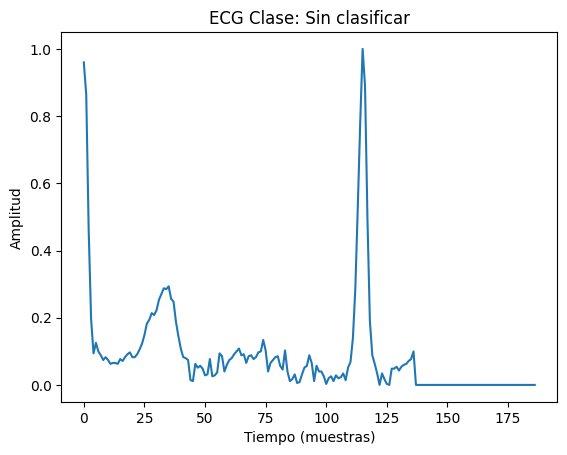

In [29]:
# Graficando un ECG
plot_ecg(X=X_train[1], y=y_train[1])

In [30]:
# Clusters con K-means
train_kmeans = KMeans(n_clusters=5, random_state=SEED)
train_clusters = train_kmeans.fit_predict(X_train)

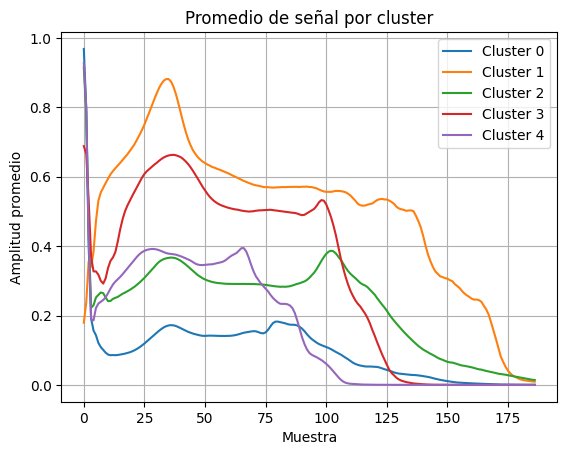

In [31]:
plot_clusters(X=X_train, clusters=train_clusters, n_clusters=5)

In [32]:
# Hacemos un conteo por clases
unique, counts = np.unique(y_train, return_counts=True)
for c, n in zip(unique, counts):
	if not np.isnan(c):
		c = int(c)
	print(f"Clase {c}: {n} muestras ({n/len(y_train)*100:.2f}%)")

Clase 0: 36236 muestras (41.39%)
Clase 1: 1112 muestras (1.27%)
Clase 2: 2894 muestras (3.31%)
Clase 3: 321 muestras (0.37%)
Clase 4: 3216 muestras (3.67%)
Clase nan: 43775 muestras (50.00%)


In [33]:
n_classes = 5

y_valid = y_train[~np.isnan(y_train)]
y_valid = y_valid[y_valid >= 0].astype(int)

print("Clases en y_valid:", np.unique(y_valid))

present_classes = np.unique(y_valid)
weights_partial = compute_class_weight(
	class_weight="balanced",
	classes=present_classes,
	y=y_valid
)

full_weights = np.zeros(n_classes, dtype=np.float32)
for c, w in zip(present_classes, weights_partial):
	full_weights[int(c)] = float(w)

class_weights = torch.tensor(full_weights, dtype=torch.float32).to(DEVICE)
print("Pesos por clase (0..4):", class_weights.cpu().numpy())

Clases en y_valid: [0 1 2 3 4]
Pesos por clase (0..4): [ 0.24163263  7.873921    3.025501   27.276636    2.7225747 ]


## **6. SimCLR**

### **6.1 Augmentaciones para SimCLR**

#### **6.1.a Augmentaciones para SimCLR utilizando Tsaug**

In [34]:
class SimCLRAugment:
    def __init__(self):
        self.aug = (
            TimeWarp(n_speed_change=3, max_speed_ratio=2.0)
            + Drift(max_drift=(0.1, 0.3))
            + AddNoise(scale=0.01)
        )

    def __call__(self, x: np.ndarray):
        a1 = self.aug.augment(x[np.newaxis, ...])[0]
        a2 = self.aug.augment(x[np.newaxis, ...])[0]
        return a1, a2
    
simclr_augment = SimCLRAugment()

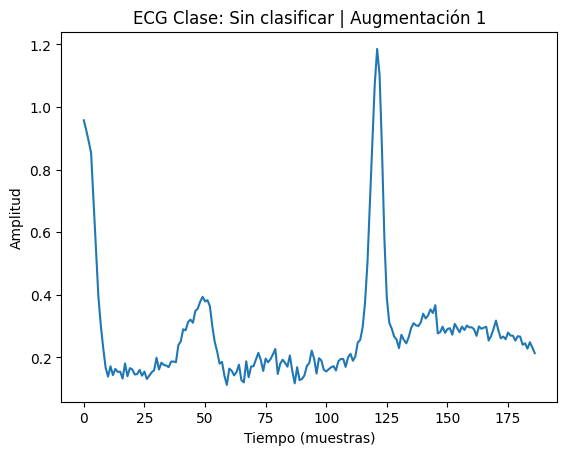

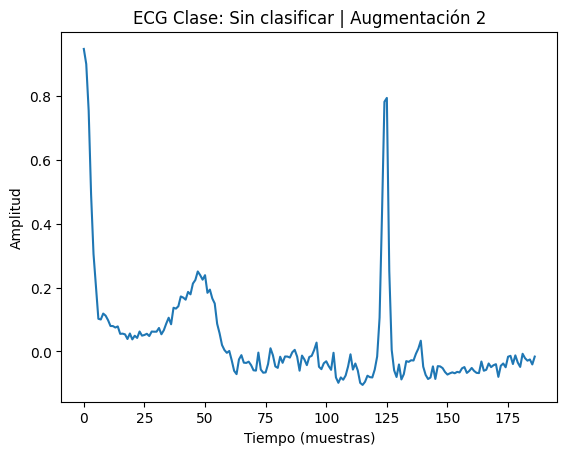

In [35]:
aug1, aug2 = simclr_augment(X_train[1])
plot_ecg(X=aug1, y=y_train[1], aug=True, aug_title="Augmentación 1")
plot_ecg(X=aug2, y=y_train[1], aug=True, aug_title="Augmentación 2")

#### **6.1.b Augmentaciones para SimCLR utilizando torch-audiomentations**

In [36]:
"""
torchaudio_augmenter = Compose([
	AddColoredNoise(p=0.5),
	TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
	PitchShift(min_transpose_semitones=-2, max_transpose_semitones=2, p=0.5)
])

def simclr_tsaug_augmentation(x):
	aug1 = torchaudio_augmenter.augment(x)
	aug2 = torchaudio_augmenter.augment(x)
	return aug1, aug2
"""

'\ntorchaudio_augmenter = Compose([\n\tAddColoredNoise(p=0.5),\n\tTimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),\n\tPitchShift(min_transpose_semitones=-2, max_transpose_semitones=2, p=0.5)\n])\n\ndef simclr_tsaug_augmentation(x):\n\taug1 = torchaudio_augmenter.augment(x)\n\taug2 = torchaudio_augmenter.augment(x)\n\treturn aug1, aug2\n'

#### **6.2 Dataset para SimCLR**

In [37]:
class SimCLRDataset(Dataset):
    def __init__(self, X, y=None, transform=None, dtype=np.float32):
        self.X = np.asarray(X, dtype=dtype)
        self.y = None if y is None else np.asarray(y)
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        x = self.X[index]

        if self.transform is not None:
            a1, a2 = self.transform(x)
        else:
            a1 = a2 = x

        x1 = torch.from_numpy(np.asarray(a1, dtype=np.float32))
        x2 = torch.from_numpy(np.asarray(a2, dtype=np.float32))

        if self.y is None:
            return x1, x2

        y = self.y[index]
        y = torch.as_tensor(y)
        return (x1, x2), y

In [38]:
simclr_train_dataset = SimCLRDataset(X=X_train, y=y_train, transform=simclr_augment)
simclr_test_dataset = SimCLRDataset(X=X_test, y=y_test)

#### **6.3 DataLoaders para SimCLR**

In [39]:
simclr_train_dataloader = DataLoader(
	dataset=simclr_train_dataset,
	batch_size=BATCH_SIZE,
	shuffle=True,
	drop_last=True,
	num_workers=NUM_WORKERS,
	pin_memory=(DEVICE.type != "cpu")
)

simclr_test_dataloader = DataLoader(
	dataset=simclr_test_dataset,
	batch_size=BATCH_SIZE,
	shuffle=False,
	drop_last=False,
	num_workers=NUM_WORKERS,
	pin_memory=(DEVICE.type != "cpu")
)

#### **6.4 Modelo SimCLR**

In [40]:
class SimCLRModel(pl.LightningModule):
	def __init__(self):
		super().__init__()

		resnet = torchvision.models.resnet18()
		self.backbone = nn.Sequential(*list(resnet.children())[:-1])

		hidden_dim = resnet.fc.in_features
		self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, SIGNALS)

		self.criterion = NTXentLoss()

	def forward(self, x):
		h = self.backbone(x).flatten(start_dim=1)
		z = self.projection_head(h)
		return z
	
	def training_step(self, batch, batch_idx):
		(x0, x1), _, _ = batch
		z0 = self.forward(x0)
		z1 = self.forward(x1)
		loss = self.criterion(z0, z1)
		self.log("training_loss_ssl", loss)
		return loss
	
	def configure_optimizers(self):
		optim = torch.optim.SGD(
			params=self.parameters(),
			lr=LEARNING_RATE,
			momentum=MOMENTUM,
			weight_decay=WEIGHT_DECAY
		)
		scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
			optimizer=optim,
			T_max=EPOCHS
		)
		return [optim], [scheduler]

#### **6.5 Entrenamiento SimCLR**

In [ ]:
simclr_model = SimCLRModel()
trainer = pl.Trainer(
	max_epochs=EPOCHS,
	devices=1,
	accelerator="gpu"
)
trainer.fit(
	simclr_model,
	simclr_train_dataloader
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M | train
1 | projection_head | SimCLRProjectionHead | 358 K  | train
2 | criterion       | NTXentLoss           | 0      | train
-----------------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.141    Total estimated model params size (MB)
77        Modules in train mode
0         Modules in eval mode
c:\Users\cinto\Repositorios\INF395-Redes-Neuronales\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
